## Problem Statement
 1. Create a report on key insights derived from Exploratory Data Analysis

 2. Create a multi-class prediction model to predict the species of plant which will survive in the neighborhood of a given environment.

 3. Create key segments for all the plants (train + test) based on the average sunlight received throughout the day and their distance from waterbody to identify which segments of plants are getting enough sunlight and water vs which ones are not. This will help in mobilizing resources to track growth of trees appropriately 



## Required sections in the Jupyter Notebook - 
1. Exploratory Data Analysis

2. Data Preprocessing --handling outliers ( imputation,Removal )

3. Data Engineering

4. Data Preparation for Predictive Modeling

5. Classification Model Predictions (at least 3 different predictive models) with hyperparameter tuning.

6. Comparison of model using performance KPIs, Training & Testing Time

7. Final predictive model recommendation 

## Instructions to go through the entire challenge:
This is divided into 13 notebooks and 4 CSV files:
1. Introductory notebook(Current)
2. 12 notebooks for six models for two types of datasets
    -- The notebooks with suffix "RR" is for reduced and resampled data, while the suffix "CU" is for complete unsampled data
3. Performance Comparison
4. Final Plant segmentation
5. Train and Test CSV files- 2 each(Encoded versions of complete unchanged data and reduced resampled data)
    -- The files with suffix _orgnl_ for unsampled and _rsmpl_ for reduced resampled data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Loading train and test data

In [39]:
df_train = pd.read_csv('/content/drive/My Drive/capstone_train.csv')
df_test = pd.read_csv('/content/drive/My Drive/capstone_test.csv')

(116203, 13)

In [14]:
#correcting a typo in the target variable for both train and test data
df_train.Plant_Type[df_train.Plant_Type=='Myconid:']='Myconid'
df_test.Plant_Type[df_test.Plant_Type=='Myconid:']='Myconid'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# **Exploratory Data Analysis**

### UNIVARIATE ANALYSIS

The Univariate analysis of the features can be shown with the help of the following distribution plots

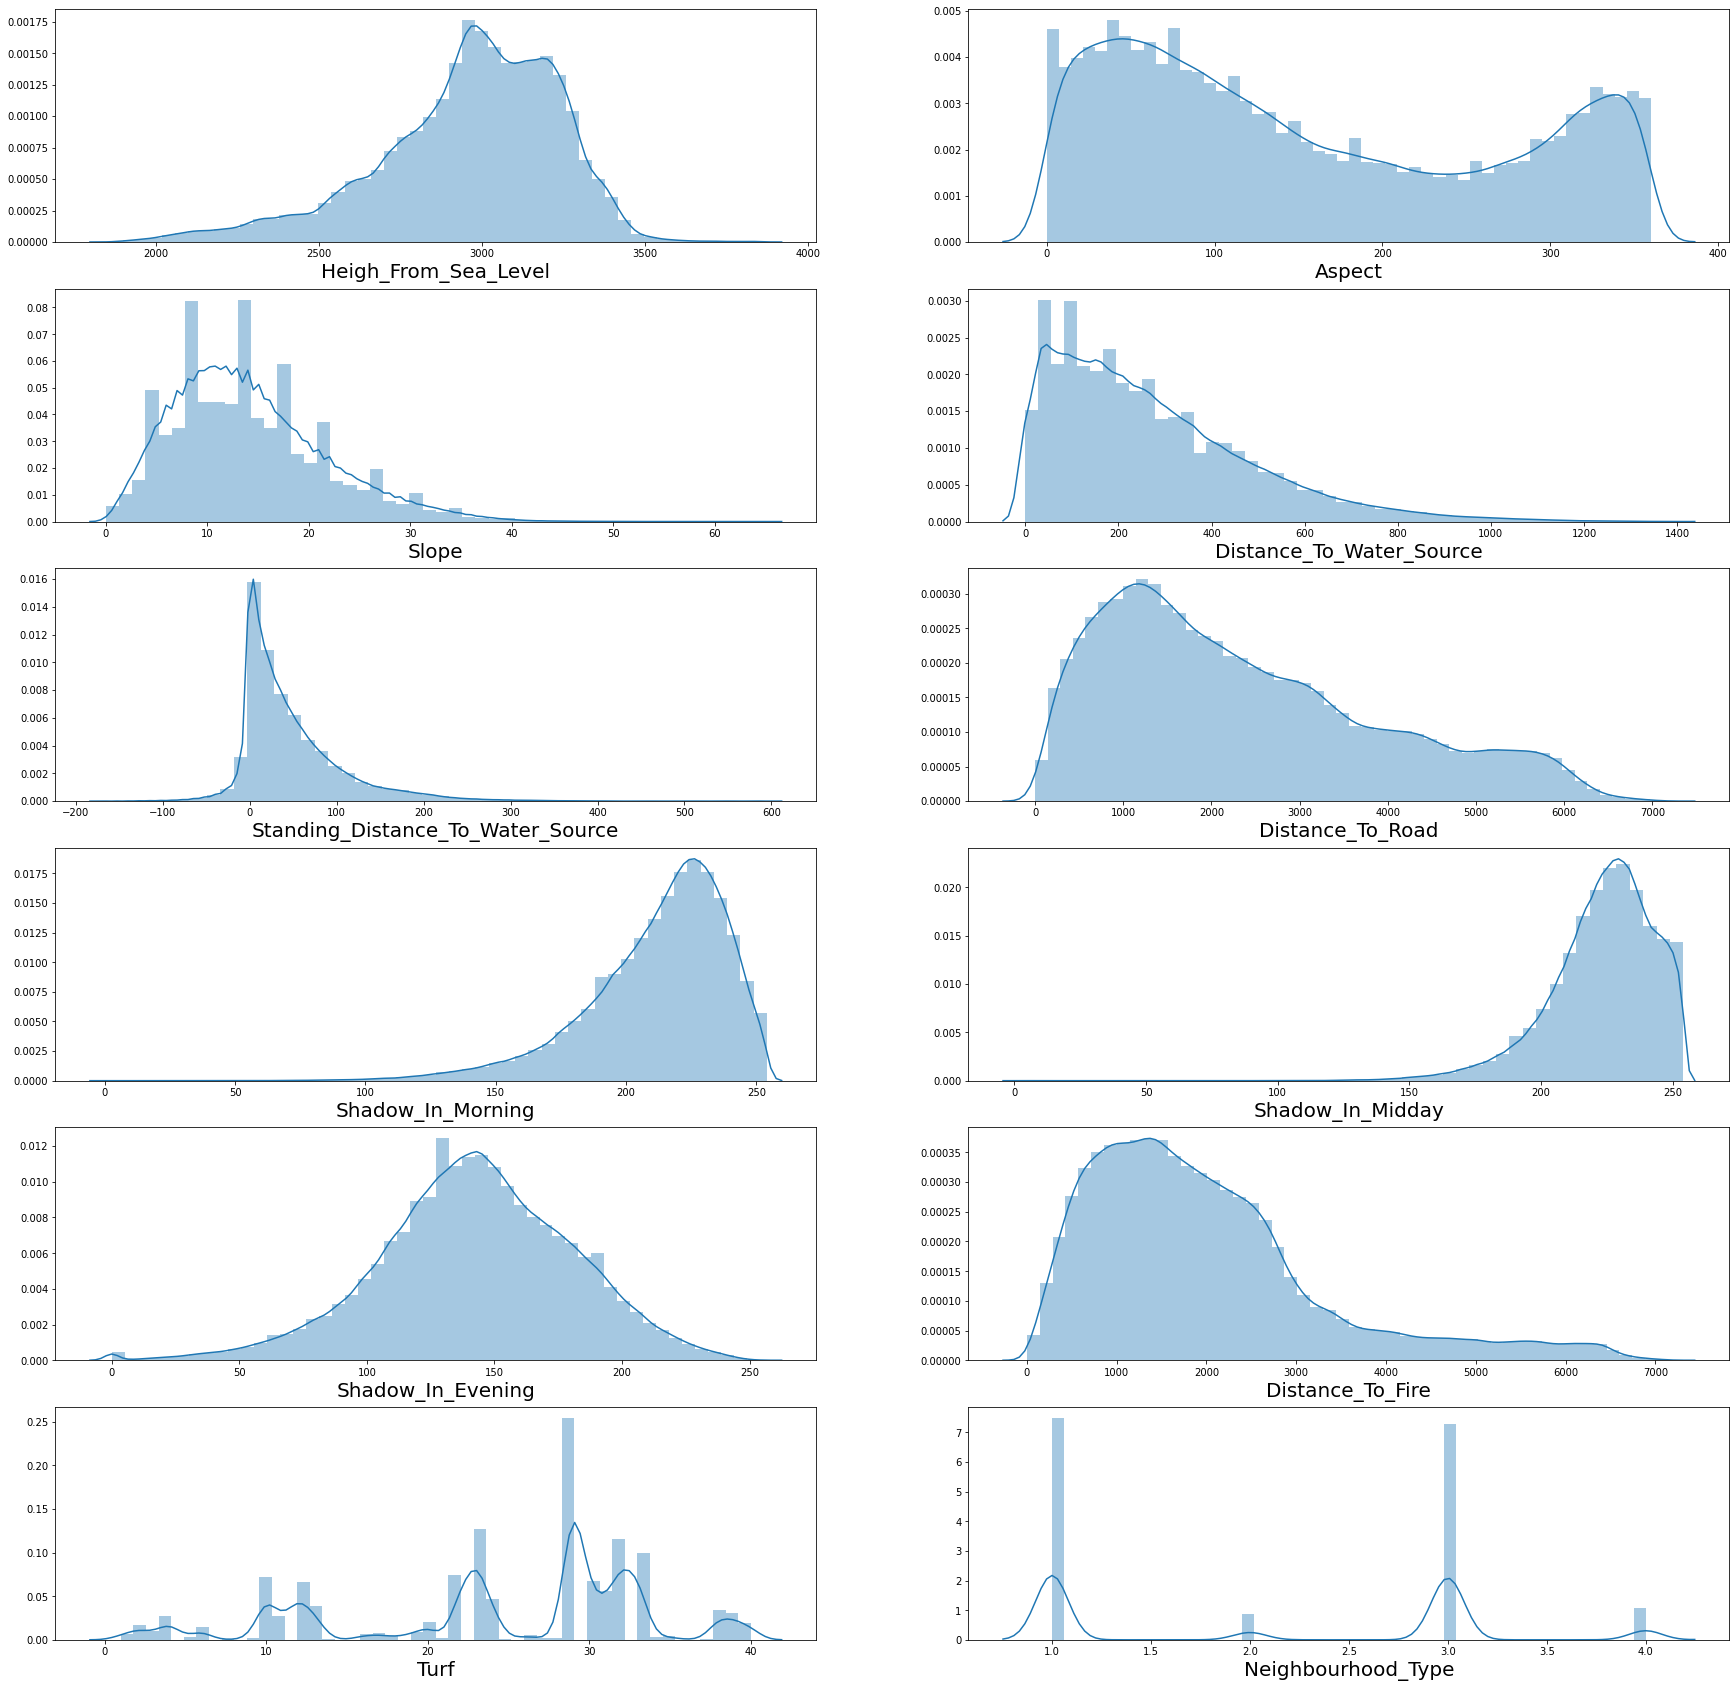

In [15]:
df = df_train.copy(deep=True)
col_names = df.iloc[:,0:12].columns.tolist()
fig, ax = plt.subplots(nrows =6,ncols =2, figsize=(30,30))
ax = ax.flatten()
for i, col_val in enumerate(col_names):
    sns.distplot(df[col_val], hist=True, ax=ax[i])
    ax[i].set_xlabel(col_val, fontsize=20)

From the plots observed above, we can make following conclusions about some of the features:

1."Height_from_sea_level" has all the values in the higher range spectrum- this indicates that most of the plants favor heights and would more likely survive better on mountains and higher plateaus.

2."Standing_distance_to_water_source" has values less than 0, which doesn't make sense. Hence the negative values must be removed from the dataset

3."Distance_to_water_source" has a lot of values in the range 0-200, this indicates that the plants have are mostly present near the water sources, which is totally logical as plants require water, also this concludes that whatever type of plant is there, it would require water for its survival.

4.'Aspect' parameter is spread across all possible values and hence indicates the uniform spread across the planet

5.'Turf', although has values across all 40 domains- it has more density towards the higher end of the spectrum values

6.'Neighbourhood' has values 1 and 3 for most of the plants and hence their favorability

### **Outlier detection analysis**

We will be using boxplots for the features to observe how their data spreads across its various quartiles

We will use similar approach to subplots to plot all of them

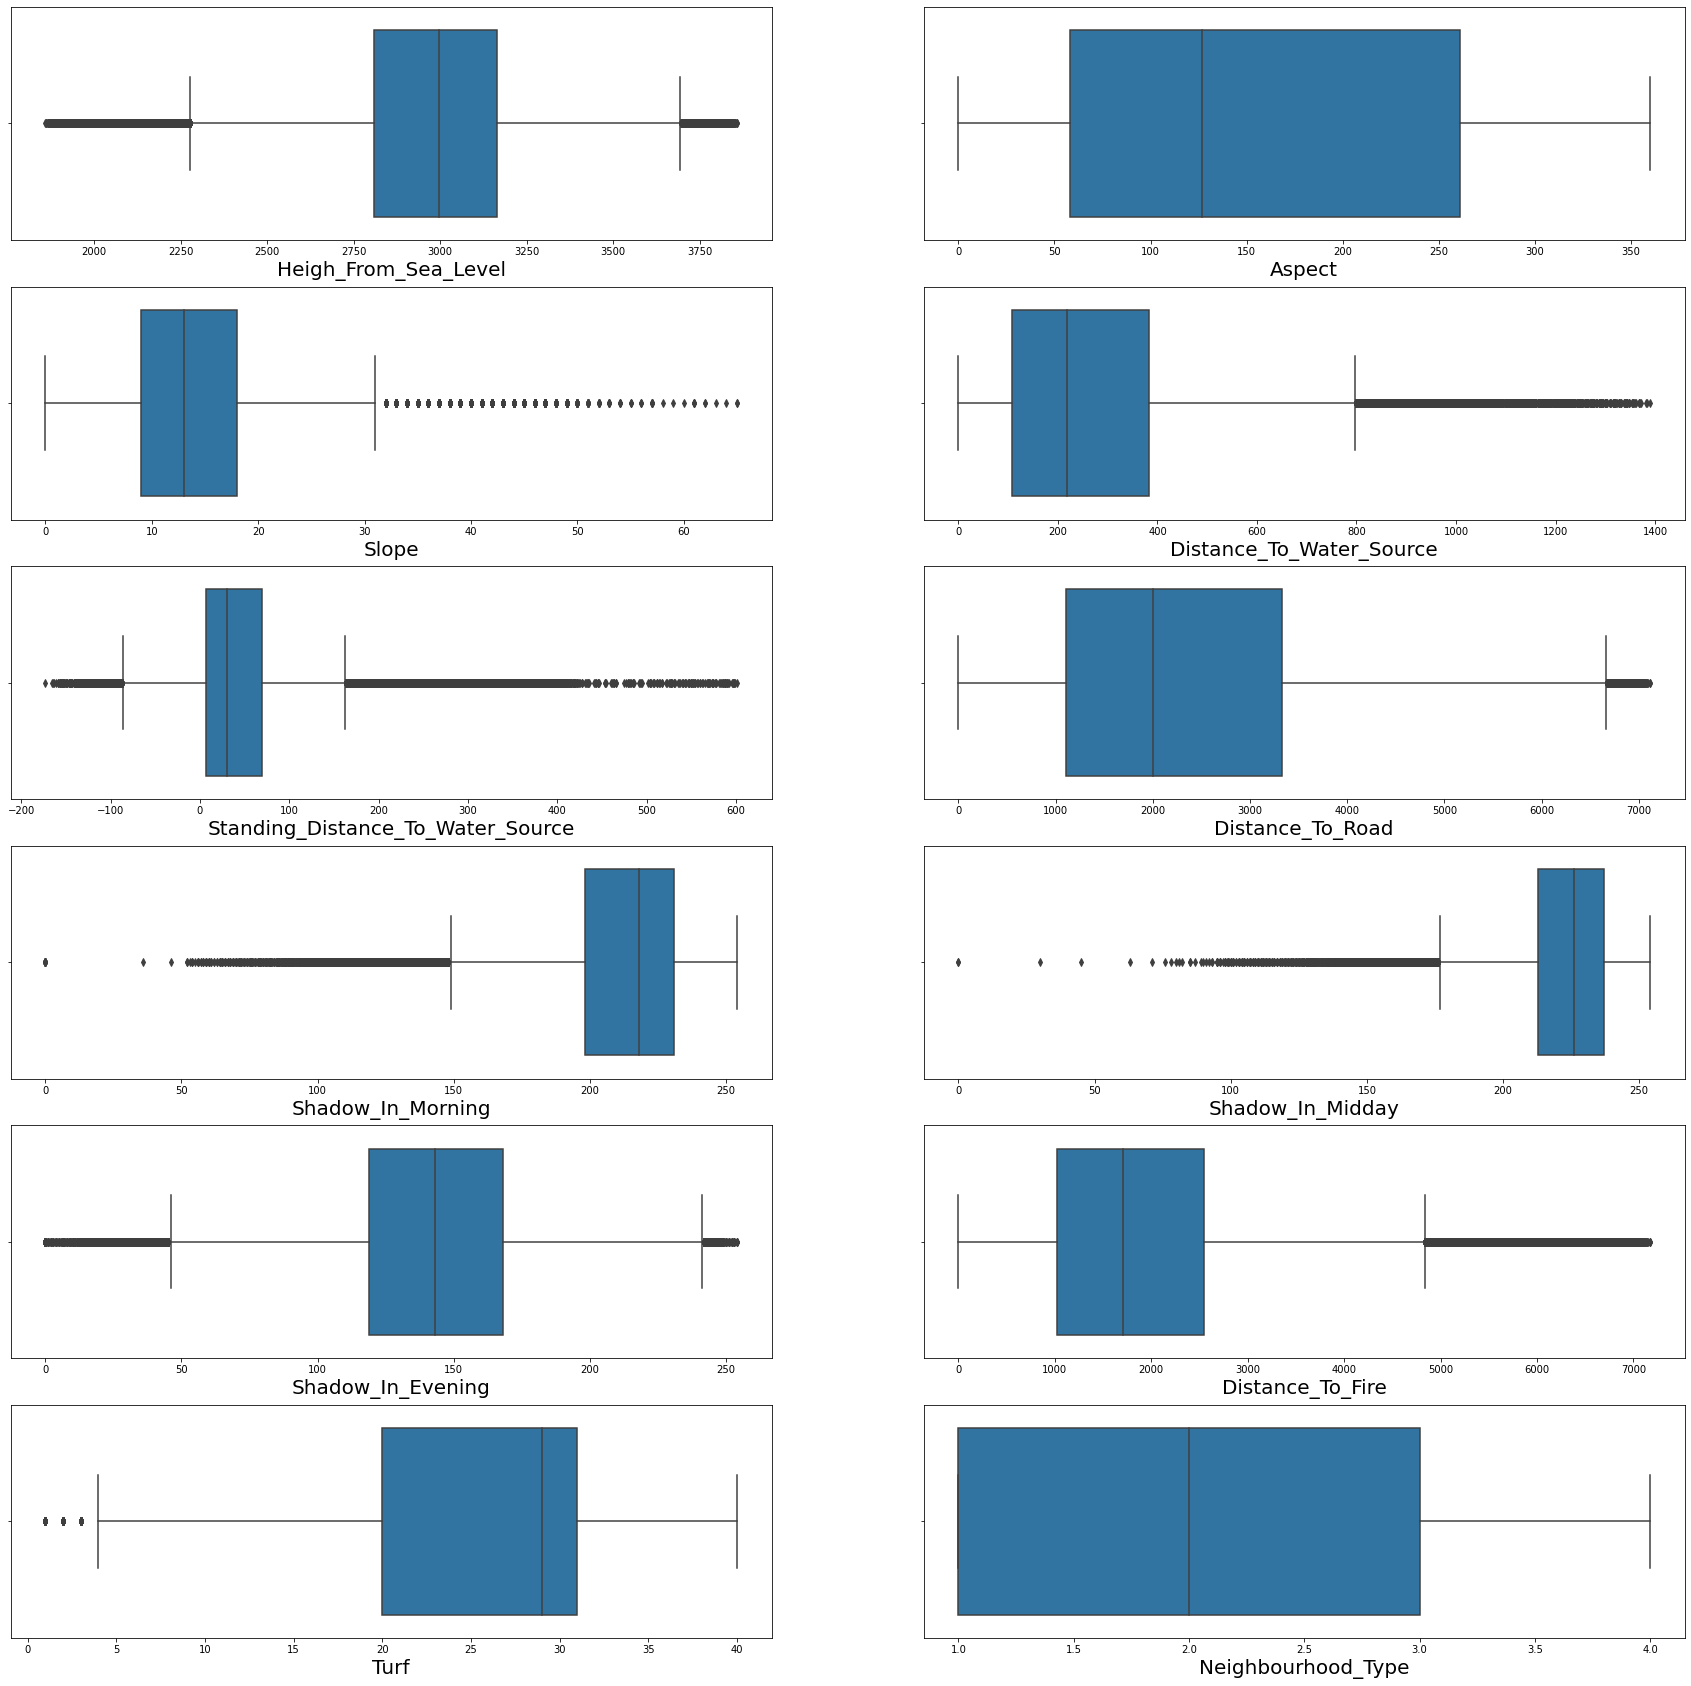

In [6]:
fig, ax = plt.subplots(nrows =6,ncols =2, figsize=(30,30))
ax = ax.flatten()
for i, col_val in enumerate(col_names):
    sns.boxplot(df[col_val], ax=ax[i])
    ax[i].set_xlabel(col_val, fontsize=20)

From the above plots we can see that outliers do exist across some of the features like the slope, the shadows and the distance from water sources


### **RELATING FEATURES AND OUTPUTS USING CORRELATION**

We will now calculate and plot the correlation matrix to identify the dependence of features on other features and the outputs

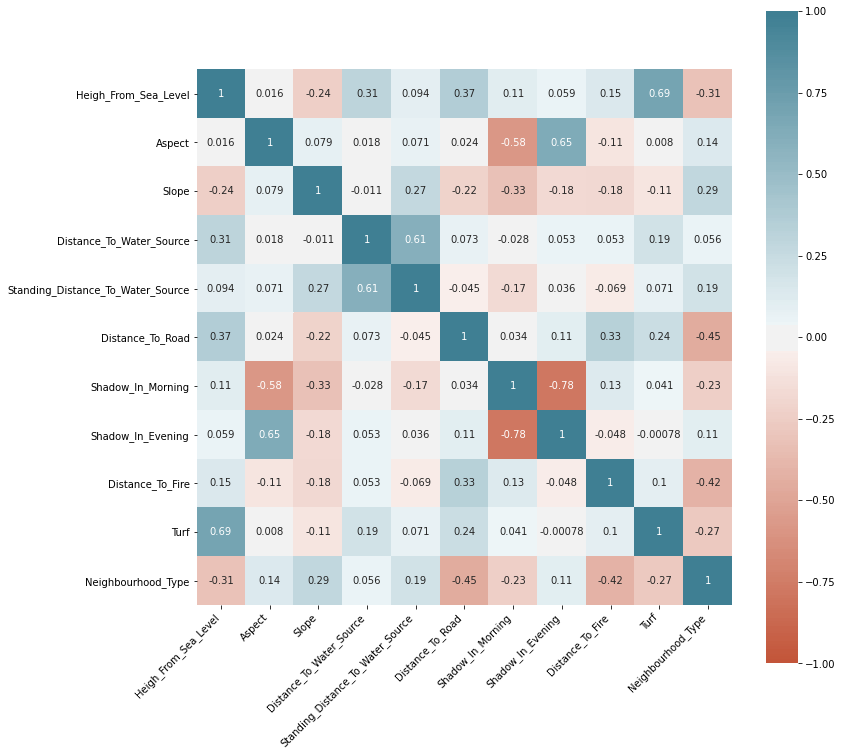

In [ ]:
#correlation plot for all features
corr_df = df_nna1.corr()
fig, ax = plt.subplots(figsize=(12,12))

ax = sns.heatmap(
    corr_df, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

We can see here that Shadow in morning and Shadow in evening are very highly negatively correlated which makes sense because the Sun is at exact opposite positions during those times of the day.

++
Since the correlation functions only for numerical values:


For calculating feature and output correlation, we use something called as correlation ratio- 

Mathematically, it is defined as the weighted variance of the mean of each category divided by the variance of all samples; in human language, the Correlation Ratio answers the following question: Given a continuous number, how well can you know to which category it belongs to?

In [ ]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        CR = 0.0
    else:
        CR = np.sqrt(numerator/denominator)
    return CR

This function takes in numpy arrays and calculates the weighted variance of mean divided by each class mean- hence we have to pass the input to this function as arrays and store the output of each feature correlation with output in a dataframe

Another dataframe has been created that displays the correlation ratio for all features with respect to the output

In [ ]:
cols = df_nna1.iloc[:,0:11].columns.tolist()
em1 =[]
cor_value =[]
feature_name =[]
for i in cols:
    if i != 'Plant_type':
        CR = correlation_ratio(np.array(df_nna1.Plant_Type), np.array(df_nna1[i]))
        em1.append([CR,i])
for i in sorted(em1,reverse =True):
    cor_value.append(i[0])
    feature_name.append(i[1])
df_corr = pd.DataFrame(list(zip(feature_name, cor_value)), 
               columns =['Feature', 'Correlation_with_output'])
df_corr

,Feature,Correlation_with_output
0,Heigh_From_Sea_Level,0.784769
1,Turf,0.641842
2,Neighbourhood_Type,0.467119
3,Distance_To_Road,0.309191
4,Slope,0.271371
5,Distance_To_Fire,0.263382
6,Shadow_In_Morning,0.179669
7,Distance_To_Water_Source,0.154184
8,Standing_Distance_To_Water_Source,0.110237
9,Shadow_In_Evening,0.102935


# **Data Preprocessing**

### MISSING AND INCORRECT VALUES DETECTION AND ANALYSIS

Let's first remove the rows with negative standing distance values

In [ ]:
df = df[df['Standing_Distance_To_Water_Source'] >= 0]

We will now check if there are NA values existing across the different features

The following code block will extract all features from the dataframe and store them as keys and their number of NAs as values in a dictionary

In [ ]:
nd={}
for i in df.columns:
    if df[i].isnull().sum()>0:
        nd[i] = df[i].isna().sum()
nd
# df_nna = df.dropna(axis='columns')

{'Shadow_In_Midday': 84238}

We just have one feature across the entire dataframe which has 93033 NA values:
Now, we have 3 options -

1.Drop the entire column with NA values- sounds like an option, because with 20% of data not available, we can actually drop the column

2.Drop the rows with NA values-doesn't sound a very good option, because we will be straight up losing around 20 % of the data

3.Impute the present values of NA with some other value- mean, median or any other statistically significant value corresponding to that column-sounds another good option, because we will retain the complete data and will be able to use it for further insights

Creating 2 dataframes for handling missing values to be used later while building models

In [ ]:
#creating another dataframe with no null values by using option 1
df_nna1 = df.dropna(axis='columns')
#creating another dataframe with no null values by using option 2
dfnna2= df.copy(deep =True)
cols = dfnna2.columns.tolist()
for i in cols:
    if sum(dfnna2[i].isnull())!=0:
        dfnna2[i].fillna(int(np.nanmean(dfnna2[i])),inplace=True)

### **CLASS DISTRIBUTION**

Frequency distribution for output feature-clearly shows that the first 2 classes are occupying the majority of the records

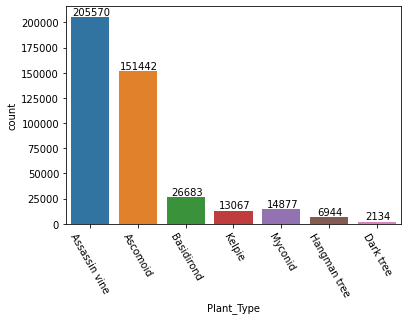

In [19]:
y = sns.countplot(x="Plant_Type", data=df_nna1)
plt.xticks(rotation=300)
for p in y.patches:
    y.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (1,5),
                   textcoords = 'offset points')

# Data Engineering

## Here, we will be trying to build models on the basis of both unsampled data and resampled with shrinkage

The following cell starts resampling data with shrinkage

### RESAMPLING TO DEAL WITH CLASS IMBALANCE

To tackle this situation- we will perform resampling- over or under sampling


Oversampling- increases the size of minority classes to match that of majority- while this does ensures class balance-this comes at a cost of a huge data set, which is almost twice or thrice the origninal data. Also it requires a dataset with no NA values, we can here use any of the dataframes created previously. For simplicity, we will take the one with dropped column


Undersampling-decreases the size of majority classes to match that of minority classes, however it has a high risk of important data loss

In [10]:
#we will perform oversampling using SMOTE
sm = SMOTE()
X_res, y_res = sm.fit_resample(df_nna1.iloc[:,0:11],df_nna1.iloc[:,11])
X_res.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(1438990, 11)

Thus, the dimensions of the resultant X vector is almost 4 times of the original dataset dimension - 420K -> 1.4M

Hence we have to make sure that, size remains within bounds along with class balancing.

In order to do that, we will make 2 dictionaries with classes which are required to be undersampled and which are required to be oversmpled. Also, we are manually assigning the numbers to 15000 for each class label.

Here the number assigned to the class is on the basis of the above plot


In [ ]:
x_over = {'Dark tree': 15000,
 'Hangman tree': 15000,
 'Myconid': 15000,
 'Kelpie': 15000}
x_under = {'Ascomoid': 15000,
 'Assassin vine': 15000,
 'Basidirond':  15000}

Now the dataset is close to 465K values and 11 columns(after dropping the column with NA values)

We will try to perform oversampling and undersampling to reduce the size of data to see if there is any major change with respect to original distribution and if there isn't any, we can proceed with it.


### Resampling and reducing the data size

We will pipe these 2 approaches using a Pipeline
This will make sure that class balancing and dataset size preservation go together

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

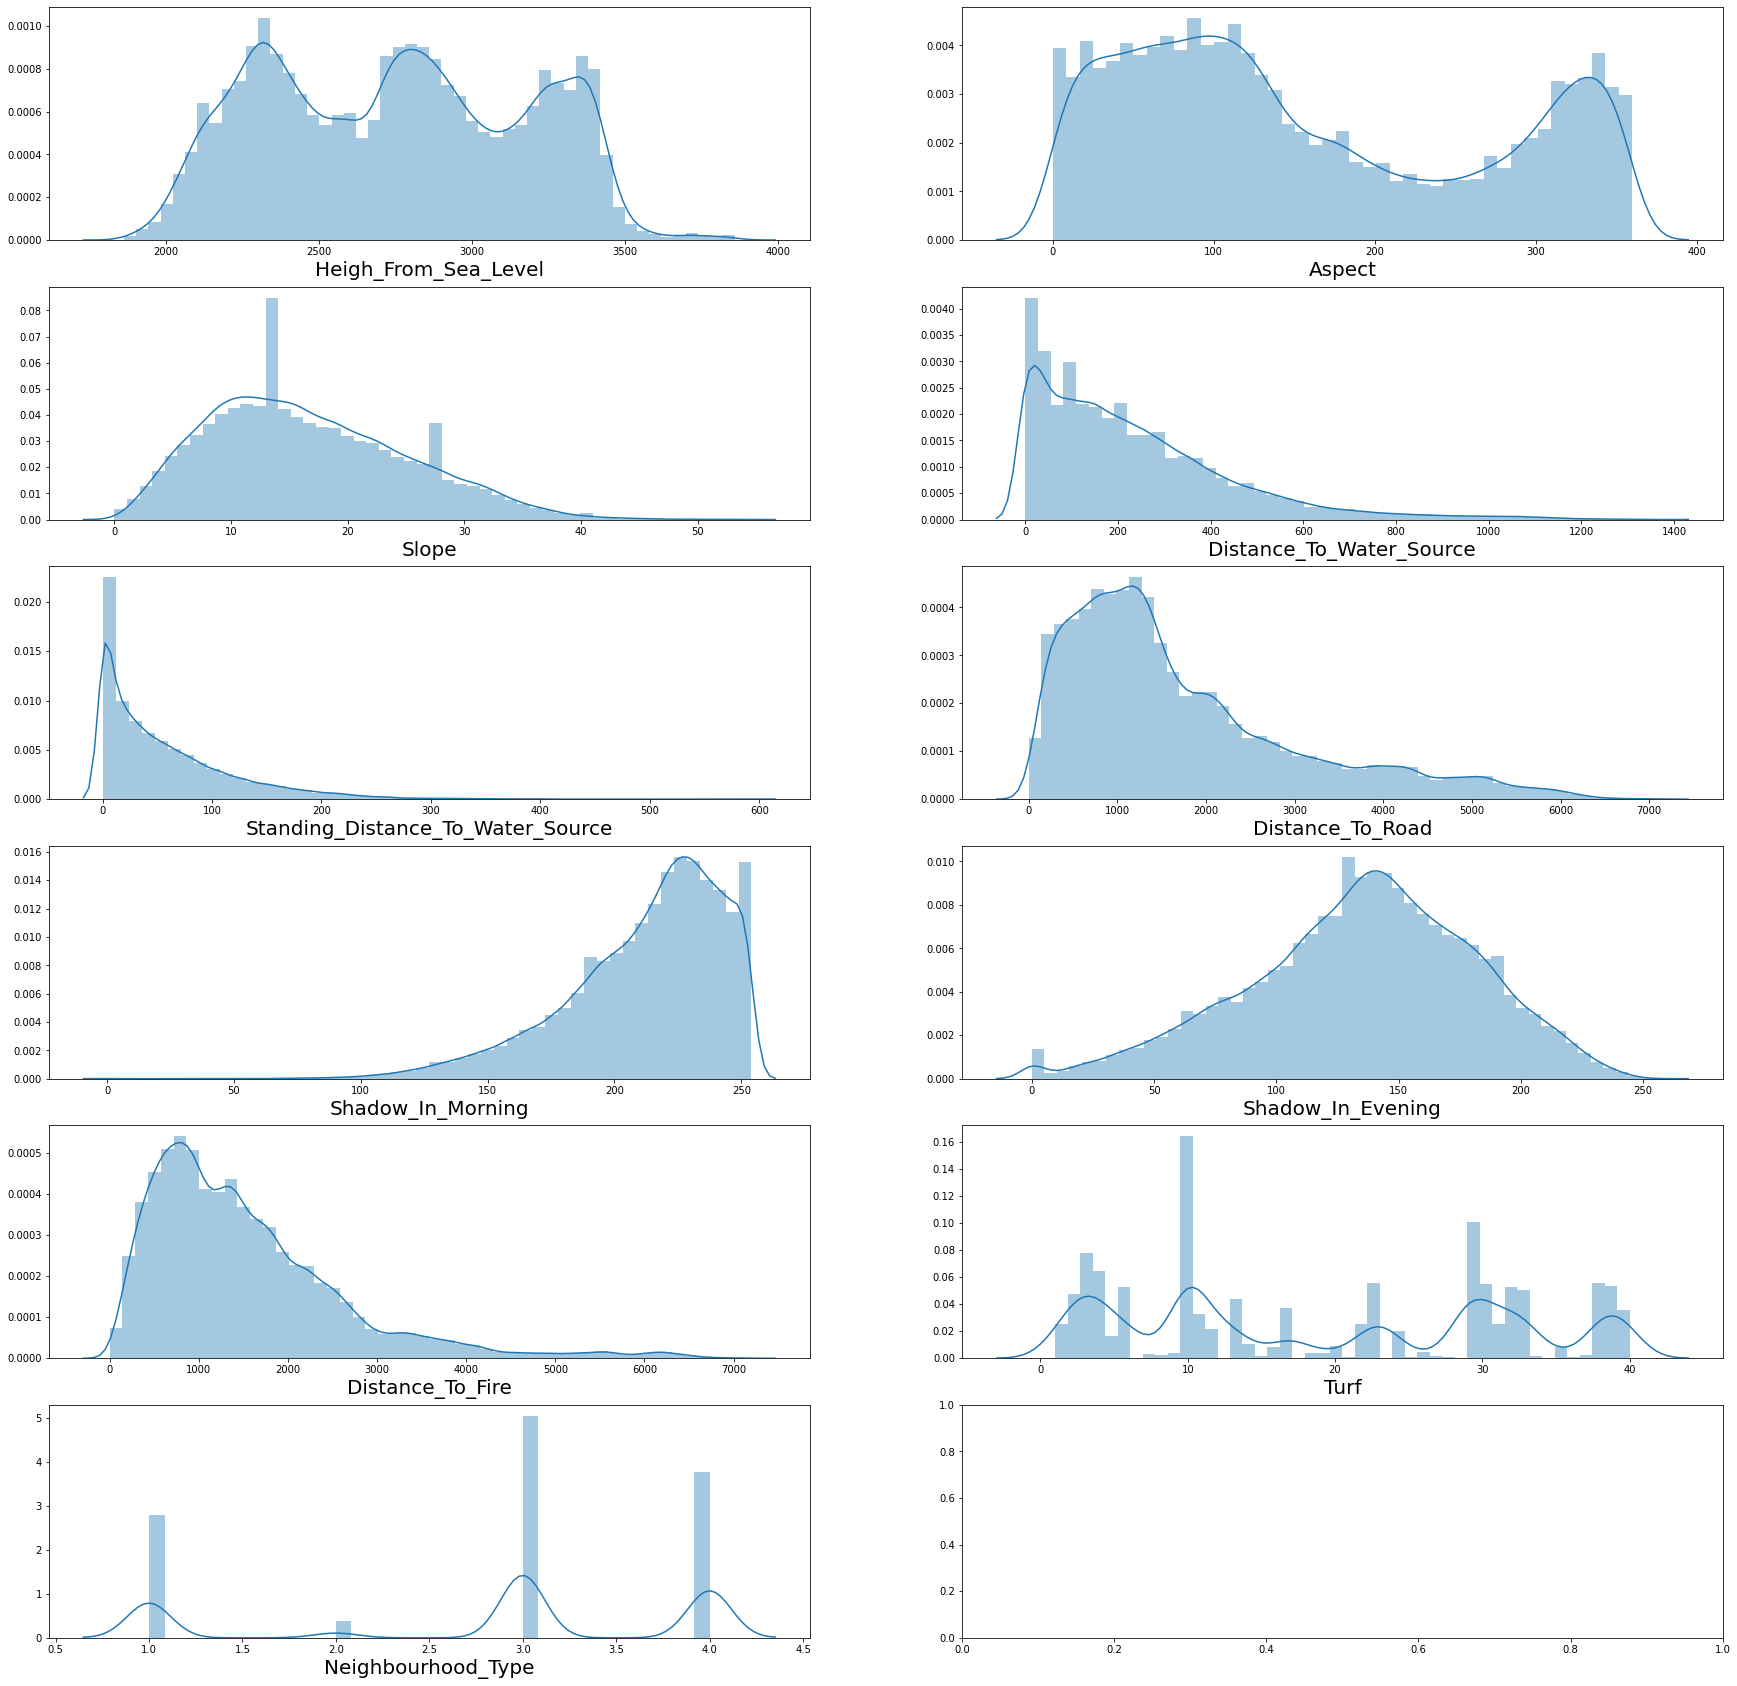

In [22]:
over = SMOTE(sampling_strategy=x_over)
under = RandomUnderSampler(sampling_strategy=x_under)
pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_resample, y_resample = pipeline.fit_resample(df_nna1.iloc[:,0:11],df_nna1.iloc[:,11])
df_n = pd.concat([pd.DataFrame(X_resample),pd.DataFrame(y_resample)],axis =1)
df_n.columns = df_nna1.columns
col_names =df_n.columns.tolist()
fig, ax = plt.subplots(nrows =6,ncols =2, figsize=(30,30))
ax = ax.flatten()
for i, col_val in enumerate(col_names):
  if col_val != "Plant_Type":
    sns.distplot(df_n[col_val], hist=True, ax=ax[i])
    ax[i].set_xlabel(col_val, fontsize=20)

Here we can see that the original distribution has minor changes to the original data when it is diminished.

Also it is observable that there exists uniformity among some of the features and are not concentrated across a value

Hence we can use the reduced data- it will help us in improving time and computational complexity with the same type of distribution


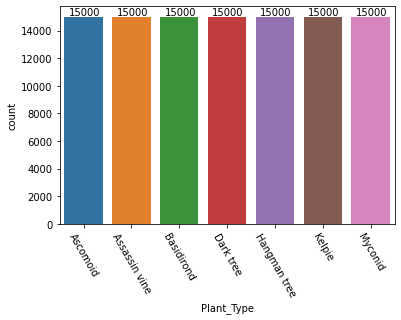

In [23]:
y = sns.countplot(x="Plant_Type", data=df_n)
plt.xticks(rotation=300)
for p in y.patches:
    y.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (1,5),
                   textcoords = 'offset points')

As we can see from the shape of the resampled X vector and the histogram of the Y vector, we can see the classes are now perfectly balanced and we can use it to build our classifiers

# Data Preparation for Predictive Modelling

## Now we will create copies of training and testing data with encoding

Now, we know that two features- 'Turf' and 'Neighbourhood_Type' are categorical and the values that they contain are not acutally numerical.

To handle those values and before feeding them to a classifier, it is necessary to make them categorical which can be acheived by One-Hot-Encoding


## Here we save a copy of encoded training data with and without resampling

In [ ]:
#one hot encoding
df_resampled = df_n.copy(deep=True)
cols_train = ['Turf',
         'Neighbourhood_Type']
for i in cols_train:
    dummy = pd.get_dummies(df_resampled[i],prefix = f"{i}")
    df_resampled = df_resampled.merge(dummy,left_index=True,right_index=True)
    temp = pd.DataFrame(df_resampled.loc[:,'Plant_Type'])
    df_resampled = df_resampled.drop([i],axis = 1)
    df_resampled = df_resampled.drop('Plant_Type',axis = 1)
    df_resampled = pd.concat([df_resampled,temp],axis=1)
df_resampled = df_resampled.drop(['Turf_15'],axis=1)
df_resampled.to_csv('Train_rsmpl.csv', index=False) 

#one hot encoding with no resampling
df_dummy = df_nna1.copy(deep=True)
cols2 = ['Turf',
         'Neighbourhood_Type']
for i in cols2:
    dummy = pd.get_dummies(df_dummy[i],prefix = f"{i}")
    df_dummy = df_dummy.merge(dummy,left_index=True,right_index=True)
    temp = pd.DataFrame(df_dummy.loc[:,'Plant_Type'])
    df_dummy = df_dummy.drop([i],axis = 1)
    df_dummy = df_dummy.drop('Plant_Type',axis = 1)
    df_dummy = pd.concat([df_dummy,temp],axis=1)
df_dummy = df_dummy.drop(['Turf_15'],axis=1)
df_dummy.to_csv('Train_orgnl.csv', index=False) 

In [33]:
df_resampled.shape

(105000, 53)

It was observed that the feature 'Turf' had no value of 15 in the test data and hence the one hot encoding of train dataset for those features resulted in one less column.
This caused conflict between the training and testing data as they are inconsistent.
So to handle this, I manually removed the feature "Turf_15" from the training data to maintain consistency.


## Here we save a copy of encoded test data with and without resampling

In [31]:
#remove the column with NAs and negative values
df_t = df_test.copy(deep = True)
df_t = df_t.dropna(axis = 'columns')
df_t = df_t[df_t['Standing_Distance_To_Water_Source'] >= 0]

#one hot encode the test data
df_tst = df_t.copy(deep=True)
cols_tst = ['Turf',
         'Neighbourhood_Type']
for i in cols_tst:
    dummy = pd.get_dummies(df_tst[i],prefix = f"{i}")
    df_tst = df_tst.merge(dummy,left_index=True,right_index=True)
    temp = pd.DataFrame(df_tst.loc[:,'Plant_Type'])
    df_tst = df_tst.drop([i],axis = 1)
    df_tst = df_tst.drop('Plant_Type',axis = 1)
    df_tst = pd.concat([df_tst,temp],axis=1)

#resample the data to match all classes
x_over = {'Dark tree': 15023,
 'Hangman tree': 15023,
 'Kelpie': 15023,
 'Myconid': 15021,
 'Basidirond':  15021}
x_under = {'Ascomoid': 15022,
 'Assassin vine': 15021}
over = SMOTE(sampling_strategy=x_over)
under = RandomUnderSampler(sampling_strategy=x_under)
pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_resample, y_resample = pipeline.fit_resample(df_tst.iloc[:,0:52],df_tst.iloc[:,52])
df_n1 = pd.concat([pd.DataFrame(X_resample),pd.DataFrame(y_resample)],axis =1)
df_n1.columns = df_tst.columns
df_n1.to_csv('Tst_rsmpl.csv',index = False)


#one hot encoding without resampling

df2 = df_test.copy(deep = True)
df2.Plant_Type[df2.Plant_Type=='Myconid:']="Myconid"
df2 = df2.dropna(axis = 'columns')
df2 = df2[df2['Standing_Distance_To_Water_Source'] >= 0]

#one hot encode the test data
df_dummy_tst = df2.copy(deep=True)
cols2 = ['Turf',
         'Neighbourhood_Type']
for i in cols2:
    dummy = pd.get_dummies(df_dummy_tst[i],prefix = f"{i}")
    df_dummy_tst = df_dummy_tst.merge(dummy,left_index=True,right_index=True)
    temp = pd.DataFrame(df_dummy_tst.loc[:,'Plant_Type'])
    df_dummy_tst = df_dummy_tst.drop([i],axis = 1)
    df_dummy_tst = df_dummy_tst.drop('Plant_Type',axis = 1)
    df_dummy_tst = pd.concat([df_dummy_tst,temp],axis=1)
df_dummy_tst.to_csv('Tst_orgnl.csv',index = False)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [38]:
df_dummy_tst.shape

(105152, 53)

### **IMPLEMENTING PREDICTIVE MODELS**

We will be implementing  Adaboosting, KNN, RandomForest, Naive Bayes(Bernoulli and Gaussian) and Gradient Boosting

1.The hyperparameter tuning aspect of 
each model will be acheived through RandomisedGridSearch- an extension of GridSearch.

2.The Randomised grid search will make sure to pick the samples randomly instead of going through the entire dataset every time and thus reduces the computation time by a significant margin with minimal loss in performance